In [1]:
from data.Safe2Unsafe import DeepAccidentDataset
from method.dynamics import InDCBFAttentionDynamics, InDCBFDynamics
from method.barriers import InDCBFAttentionBarrier, InDCBFBarrier
from method.trainers import InDCBFTrainer
import torch
import time
import pytorch_lightning as pl
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [2]:
data = DeepAccidentDataset(train_batch_size=32,val_batch_size=32,num_workers=16)
data.setup()
train_dataloader = data.train_dataloader()
test_dataloader = data.val_dataloader()

In [6]:
latent_dim = 16
barrier = InDCBFAttentionBarrier(2,latent_dim=latent_dim)
# barrier = InDCBFBarrier(2,latent_dim=latent_dim)
# model = InDCBFDynamics(2,"cuda",model="google/vit-base-patch16-224",latent_dim=latent_dim)
model = InDCBFAttentionDynamics(2,"cuda",model="google/vit-base-patch16-224",latent_dim=latent_dim)
# model = InDCBFAttentionDynamics(2,"cuda",model="openai/clip-vit-base-patch16",latent_dim=latent_dim)
# model = InDCBFAttentionDynamics(2,"cuda",model="resnet50",latent_dim=latent_dim)
# model = InDCBFAttentionDynamics(2,"cuda",model="vc1",latent_dim=latent_dim)
trainer = InDCBFTrainer(model,barrier)
checkpoint = torch.load("/root/tf-logs/InDCBF/version_0/checkpoints/last.ckpt")
# checkpoint = torch.load("/root/tf-logs/InDCBFUnfused/version_0/checkpoints/last.ckpt")
trainer.load_state_dict(checkpoint['state_dict'])
trainer.to("cuda")

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


InDCBFTrainer(
  (model): InDCBFAttentionDynamics(
    (encoder): ViTAttentionEncoder(
      (ViT): ViTModel(
        (embeddings): ViTEmbeddings(
          (patch_embeddings): ViTPatchEmbeddings(
            (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): ViTEncoder(
          (layer): ModuleList(
            (0): ViTLayer(
              (attention): ViTAttention(
                (attention): ViTSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): ViTSelfOutput(
                  (dense): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(

In [11]:
xs = []
trainer.eval()
for idx, (i,u,label) in enumerate(test_dataloader):
    i, u = i.to("cuda"), u.to("cuda")
    x,x_tide = trainer.model.simulate(i,u)
    break
import numpy as np
# xs = torch.cat(xs)
# results = torch.cat([bs,labels.unsqueeze(-1)],dim=-1).detach().numpy()
np.savetxt("./reps_vit.txt",x[0].detach().cpu().numpy())

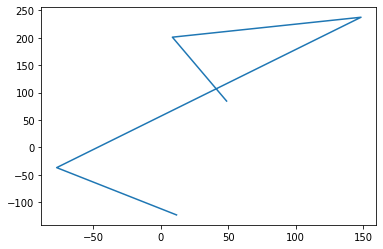

In [16]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(x[0].detach().cpu().numpy())
import matplotlib.pyplot as plt
plt.plot(X_embedded[:,0],X_embedded[:,1])

In [26]:
b_all = []
label_all = []
trainer.eval()
for idx, (i,u,label) in enumerate(test_dataloader):
    i, u = i.to("cuda"), u.to("cuda")
    x,x_tide = trainer.model.simulate(i,u)
    b = trainer.barrier(x).squeeze(-1)
    b_all.append(b.cpu())
    label_all.append(label.squeeze(-1))
import numpy as np
bs = torch.cat(b_all)
labels = torch.cat(label_all)
results = torch.cat([bs,labels.unsqueeze(-1)],dim=-1).detach().numpy()
np.savetxt("./results_indcbfunfused_vit.txt",results)

100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


In [5]:
results = np.loadtxt("./results_indcbfunfused_vit.txt")
regular = results[results[:,-1] == 0,:-1]
collision = results[results[:,-1] == 1,:-1]
acc_regular = (regular > 0).mean()
acc_collision = (collision < 0).mean()
print(acc_regular,acc_collision)

0.9788659793814433 0.2


In [24]:
b_all = []
label_all = []
trainer.eval()
for idx, (i,u,label) in enumerate(test_dataloader):
    i, u = i.to("cuda"), u.to("cuda")
    x,x_tide = trainer.model.simulate(i,u)
    b = trainer.barrier(x)
    d_b_safe = torch.autograd.grad(b.mean(),x,retain_graph=True)[0]
    with torch.no_grad():
        f, g = trainer.model.ode(x)
    gu = torch.einsum('btha,bta->bth',g.view(g.shape[0],g.shape[1],f.shape[-1],2),u)
    ascent_value = torch.einsum('bth,bth->bt', d_b_safe, (f + gu)) + b.squeeze(-1)
    b_all.append(ascent_value.cpu())
    label_all.append(label.squeeze(-1))
bs = torch.cat(b_all)
labels = torch.cat(label_all)
results = torch.cat([bs,labels.unsqueeze(-1)],dim=-1).detach().numpy()
np.savetxt("./results_indcbf_grad_resnet.txt",results)

100%|██████████| 4/4 [00:00<00:00,  9.41it/s]


In [33]:
b_all = []
label_all = []
trainer.eval()
for idx, (i,u,label) in enumerate(test_dataloader):
    i, u = i.to("cuda"), u.to("cuda")
    x,x_tide = trainer.model.simulate(i,u)
    B,T,N,H = x.shape
    weight = torch.einsum("btnh,btnh->btn",trainer.barrier.attention.expand(B,T,-1,-1),x)
    x_fused = torch.einsum("btn,btnh->btnh",weight,x).sum(2)
    b = trainer.barrier.cbf(x_fused)
    d_b_safe = torch.autograd.grad(b.mean(),x_fused,retain_graph=True)[0]
    with torch.no_grad():
        f, g = trainer.model.ode(x)
    gu = torch.einsum('btnha,btna->btnh',g.view(g.shape[0],g.shape[1],g.shape[2],f.shape[-1],2),u.unsqueeze(2).expand(-1,-1,g.shape[2],-1))
    dx = torch.einsum("btn,btnh->btnh",weight,(f + gu)).sum(2)
    ascent_value = torch.einsum('bth,bth->bt', d_b_safe, dx).unsqueeze(-1) + b
    b_all.append(ascent_value.cpu())
    label_all.append(label.squeeze(-1))
bs = torch.cat(b_all)
labels = torch.cat(label_all)
results = torch.cat([bs.squeeze(-1),labels.unsqueeze(-1)],dim=-1).detach().numpy()
np.savetxt("./results_indcbfunfused_grad_vit.txt",results)

100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


In [18]:
results = np.loadtxt("./results_indcbf_grad_vit.txt")
regular = results[results[:,-1] == 0,:-1]
collision = results[results[:,-1] == 1,:-1]
acc_regular = (regular > 0).mean()
acc_collision = (collision < 0).mean()
print(acc_regular,acc_collision)

0.9675257731958763 0.32727272727272727
